# Cloud cover masking

In [1]:
import geopandas
import matplotlib.pyplot as plt
import pyproj
import pystac
import pystac_client
import rioxarray
import s2cloudless
import shapely
import stac2dcache
import xarray as xr

from stac2dcache.utils import get_asset

## Using `s2cloudless` 

https://github.com/sentinel-hub/sentinel2-cloud-detector

In [2]:
def _read_catalog(url, stac_io):
    """
    Read STAC catalog from URL

    :param url: urlpath to the catalog root
    :return: PyStac Catalog object
    """
    url = url if url.endswith("catalog.json") else f"{url}/catalog.json"
    catalog = pystac.Catalog.from_file(url, stac_io=stac_io)
    return catalog

def _get_assets(catalog, asset_keys, item_id=None, filesystem=None):
    """
    Retrieve all required assets from the catalog.

    :param catalog: STAC Catalog object
    :param asset_keys: list of asset keys
    :param item_id:
    :param filesystem:
    :return: list of asset objects
    """
    assets = {}
    for asset_key in asset_keys:
        assets[asset_key] = get_asset(
            catalog,
            asset_key=asset_key,
            item_id=item_id,
            filesystem=filesystem,
            # load=False,
            # gdal_config_options={"GDAL_NUM_THREADS": 1, "GDAL_DISABLE_READDIR_ON_OPEN": "YES"}
        )
    return assets

In [3]:
catalog_url = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/red-glacier_copernicushub-gcp"
macaroon_path = "./macaroon.dat"
rgi_shape_url = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/GIS/Glacier/01_rgi60_Alaska.zip"
rgi_id = "RGI60-01.19773"  # RGI ID of the Red Glacier
rgi_buffer = 0.05  # latlon buffer around glacier

In [4]:
# configure connection to dCache
stac2dcache.configure(token_filename=macaroon_path)

In [5]:
# read catalog
catalog = _read_catalog(catalog_url, stac2dcache.stac_io)

In [6]:
# get Red Glacier geometry from the RGI
with stac2dcache.fs.open(rgi_shape_url) as f:
    glaciers = geopandas.read_file(f)
    
red_glacier = glaciers[glaciers["RGIId"] == rgi_id]
red_glacier_geom = red_glacier.geometry.item()

In [8]:
# select an interesting item 
for item in catalog.get_all_items():
    item_geom = shapely.geometry.shape(item.geometry)
    cc = item.properties["eo:cloud_cover"]
    if item_geom.intersects(red_glacier_geom) and cc < 10:
        break

print(item.id, item.properties["eo:cloud_cover"])

S2B_MSIL1C_20220130T214729_N0400_R129_T05VMG_20220130T220343.SAFE 4.69243632237451


In [9]:
item_geom = shapely.geometry.shape(item.geometry)
intersection = item_geom.intersection(
    red_glacier_geom.buffer(rgi_buffer)
).convex_hull

In [10]:
# download all required assets
asset_keys_clouds = ["B01", "B02", "B04", "B05", "B08", "B8A", "B09", "B10", "B11", "B12"]

assets = _get_assets(
    catalog=catalog,
    asset_keys=asset_keys_clouds,
    item_id=item.id,
    filesystem=stac2dcache.fs,
)

In [11]:
# transform bbox to UTM coordinates in order to clip before download
utm = pyproj.CRS(assets["B01"].rio.crs)
wgs84 = pyproj.CRS("EPSG:4326")
transform = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
intersection_utm = shapely.ops.transform(transform, intersection)

Warning 1: HTTP response code on http://storage.googleapis.com/gcp-public-data-sentinel-2/tiles/05/V/MG/S2B_MSIL1C_20220130T214729_N0400_R129_T05VMG_20220130T220343.SAFE/GRANULE/L1C_T05VMG_A025609_20220130T214729/IMG_DATA/T05VMG_20220130T214729_TCI.jp2.msk: 403
Warning 1: HTTP response code on http://storage.googleapis.com/gcp-public-data-sentinel-2/tiles/05/V/MG/S2B_MSIL1C_20220130T214729_N0400_R129_T05VMG_20220130T220343.SAFE/GRANULE/L1C_T05VMG_A025609_20220130T214729/IMG_DATA/T05VMG_20220130T214729_TCI.jp2.MSK: 403


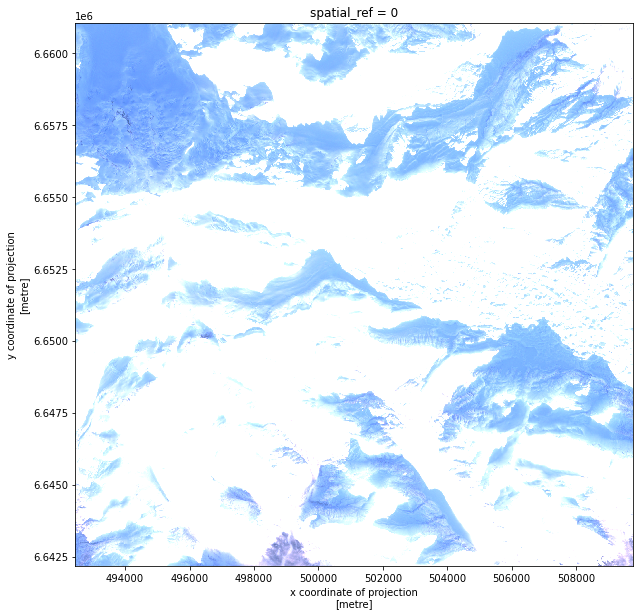

In [12]:
visual = rioxarray.open_rasterio(item.assets["visual"].get_absolute_href())
visual = visual.rio.clip_box(*intersection_utm.bounds)
visual.squeeze().plot.imshow(figsize=(10, 10))

In [13]:
# clip to interesting region
bands = [
    assets[key].rio.clip_box(*intersection_utm.bounds)
    for key in asset_keys_clouds
]

# upscale lower resolution assets
bands = [
    band.squeeze().rio.reproject_match(bands[1])
    for band in bands
]

# stack all bands
bands = xr.concat(bands, dim="band")
bands.coords["band"] = asset_keys_clouds

# transform to reflectance values
bands = bands / 10_000

# transpose to form expected by s2cloudless
bands = bands.transpose("y", "x", "band")

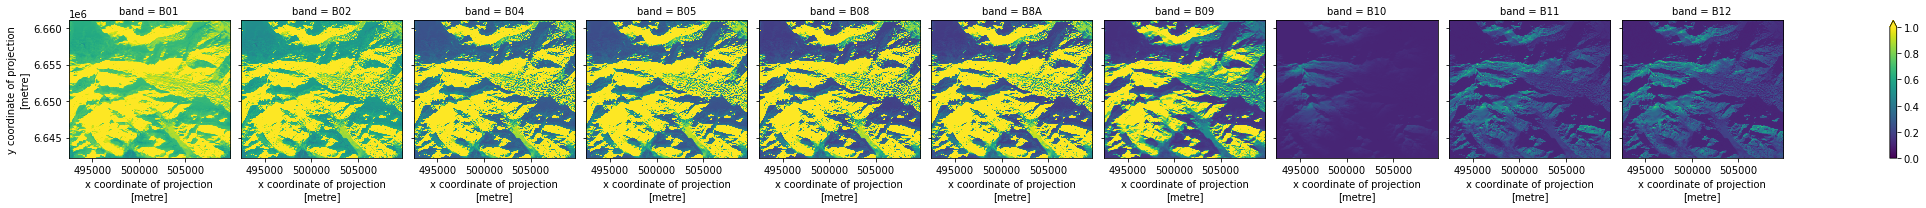

In [14]:
bands.plot.imshow(col="band", vmin=0, vmax=1)

In [15]:
# predict cloud probability map
cloud_detector = s2cloudless.S2PixelCloudDetector(all_bands=False)

cloud_probs = cloud_detector.get_cloud_probability_maps(bands.data)

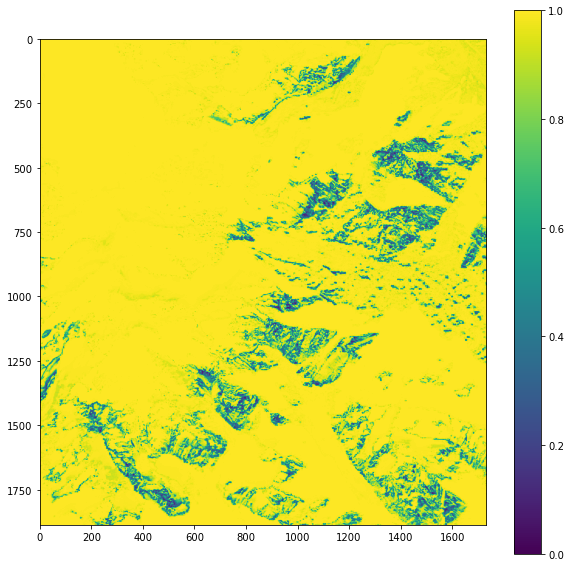

In [16]:
# plot cloud probability map
im = plt.imshow(cloud_probs, vmin=0, vmax=1)
plt.colorbar(im)
plt.gcf().set_size_inches(10, 10)

## Based on Sentinel-2 scene classification maps (`Sen2Cor` output)

https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

In [17]:
client = pystac_client.Client.open(
    "https://earth-search.aws.element84.com/v0"
)

mysearch = client.search(
    collections=["sentinel-s2-l2a-cogs"],
    intersects=shapely.geometry.mapping(intersection),
    datetime=str(item.datetime.date()),
    query=["sentinel:grid_square=MG"]
)

items = mysearch.get_all_items()
print(len(items))

1


In [18]:
items[0].properties

{'datetime': '2022-01-30T21:48:43Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32605,
 'sentinel:utm_zone': 5,
 'sentinel:latitude_band': 'V',
 'sentinel:grid_square': 'MG',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2B_MSIL2A_20220130T214729_N0400_R129_T05VMG_20220130T222739',
 'sentinel:data_coverage': 100,
 'eo:cloud_cover': 4.69,
 'sentinel:valid_cloud_cover': True,
 'sentinel:processing_baseline': '04.00',
 'created': '2022-01-31T00:30:27.846Z',
 'updated': '2022-01-31T00:30:27.846Z'}

In [19]:
item = items[0]

In [20]:
item.assets

{'thumbnail': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/5/V/MG/2022/1/30/0/preview.jpg>,
 'overview': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/5/V/MG/2022/1/S2B_5VMG_20220130_0_L2A/L2A_PVI.tif>,
 'info': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/5/V/MG/2022/1/30/0/tileInfo.json>,
 'metadata': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/5/V/MG/2022/1/30/0/metadata.xml>,
 'visual': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/5/V/MG/2022/1/S2B_5VMG_20220130_0_L2A/TCI.tif>,
 'B01': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/5/V/MG/2022/1/S2B_5VMG_20220130_0_L2A/B01.tif>,
 'B02': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/5/V/MG/2022/1/S2B_5VMG_20220130_0_L2A/B02.tif>,
 'B03': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/5/V/MG/2022/1/S2

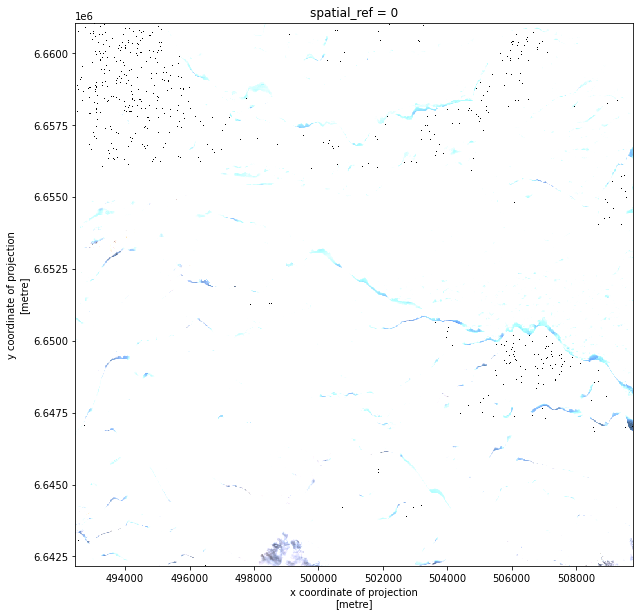

In [21]:
visual = rioxarray.open_rasterio(item.assets["visual"].get_absolute_href(), overview_level=0)
visual = visual.rio.clip_box(*intersection_utm.bounds)
visual.squeeze().plot.imshow(figsize=(10, 10))

In [22]:
# get scene classification map
scl = rioxarray.open_rasterio(item.assets["SCL"].get_absolute_href())
scl = scl.rio.clip_box(*intersection_utm.bounds)

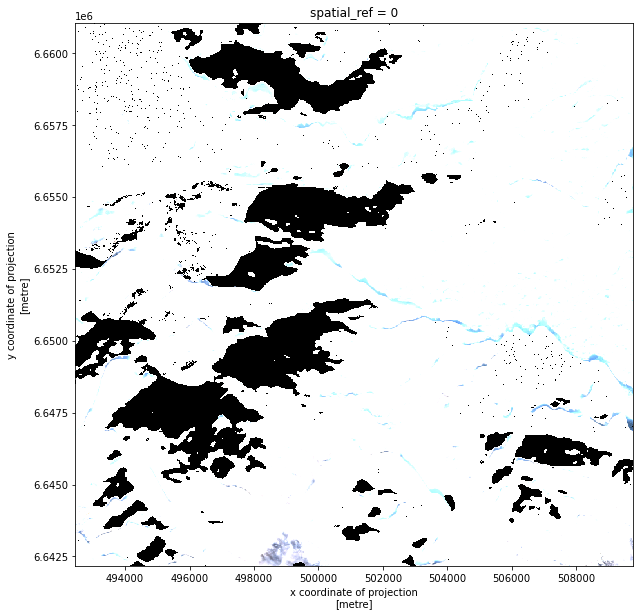

In [23]:
# plot both high and medium cloud probability
mask = scl.squeeze().isin([8, 9])
visual_masked = visual.where(~mask, other=visual.rio.nodata)
visual_masked.plot.imshow(figsize=(10, 10))

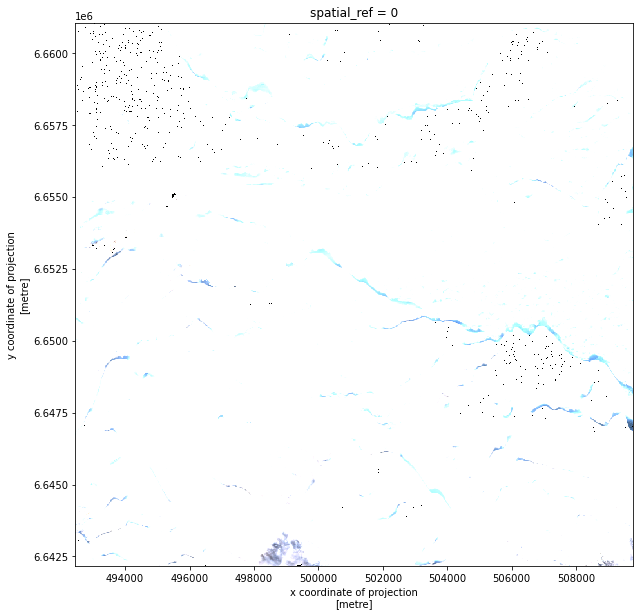

In [24]:
# plot only high cloud probability
mask = scl.squeeze().isin([9])
visual_masked = visual.where(~mask, other=visual.rio.nodata)
visual_masked.plot.imshow(figsize=(10, 10))